In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# %matplotlib notebook
%matplotlib inline

In [2]:
class Data:
    def __init__(self, params):
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.d = params['d']
        self.l = params['l']
        self.f = params['f']
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.psi1 = params['psi1']
        self.psi2 = params['psi2']
        self.psi1_dir1 = params['psi1_dir1']
        self.psi1_dir2 = params['psi1_dir2']
        self.phi0 = params['phi0']
        self.phi1 = params['phi1']
        self.bound_type = params['bound_type']
        self.approximation = params['approximation']
        self.solution = params['solution']


In [488]:
class HyperbolicSolver:
    def __init__(self, params, N, T, K):

        self.data = Data(params)

        self.N = N
        self.T = T
        self.K = K

        self.h = self.data.l / N
        self.tau = T / K
        self.sigma = (self.tau ** 2) / (self.h ** 2)

    def analyticSolve(self):
        N = self.N
        T = self.T
        K = self.K
        u = np.zeros((K, N))
        for k in range(K):
            for j in range(N):
                u[k][j] = self.data.solution(j * self.h, k * self.tau)
        return u

    def calculate(self, N, K):
        u = np.zeros((K, N))

        for j in range(0, N - 1):
            x = j * self.h
            u[0][j] = self.data.psi1(x)

            if self.data.approximation == 'p1':
                u[1][j] = self.data.psi1(x) + self.data.psi2(x) * self.tau + self.data.psi1_dir2(x) * \
                          (self.tau ** 2 / 2)
            elif self.data.approximation == 'p2':
                u[1][j] = self.data.psi1(x) + self.data.psi2(x) * self.tau + \
                          (self.data.psi1_dir2(x) + self.data.b * self.data.psi1_dir1(x) +
                           self.data.c * self.data.psi1(x) + self.data.f()) * (self.tau ** 2 / 2)

        return u

    def implicit_solver(self):
        N = self.N
        T = self.T
        K = self.K
        u = self.calculate(N, K)

        a = np.zeros(N)
        b = np.zeros(N)
        c = np.zeros(N)
        d = np.zeros(N)

        for k in range(2, K):
            for j in range(1, N):
                a[j] = self.sigma
                b[j] = -(1 + 2 * self.sigma)
                c[j] = self.sigma
                d[j] = -2 * u[k - 1][j] + u[k - 2][j]

            if self.data.bound_type == 'a1p2':
                b[0] = -1 / self.h
                c[0] = 1 / self.h
                d[0] = 1 / (self.data.beta - self.data.alpha / self.h) * self.data.phi0(k * self.tau)

                a[-1] = -self.data.gamma / self.h / (self.data.delta + self.data.gamma / self.h)
                b[-1] = 1
                d[-1] = 1 / (self.data.delta + self.data.gamma / self.h) * self.data.phi1(k * self.tau)
            elif self.data.bound_type == 'a2p3':
                k1 = 2 * self.h * self.data.beta - 3 * self.data.alpha
                omega = self.tau ** 2 * self.data.b / (2 * self.h)
                xi = self.data.d * self.tau / 2

                b[0] = 4 * self.data.alpha - self.data.alpha / (self.sigma + omega) * \
                       (1 + xi + 2 * self.sigma - self.data.c * self.tau ** 2)
                c[0] = k1 - self.data.alpha * (omega - self.sigma) / (omega + self.sigma)
                d[0] = 2 * self.h * self.data.phi0(k * self.tau) + self.data.alpha * d[1] / (-self.sigma - omega)
                a[-1] = -self.data.gamma / (omega - self.sigma) * \
                        (1 + xi + 2 * self.sigma - self.data.c * self.tau ** 2) - 4 * self.data.gamma
                d[-1] = 2 * self.h * self.data.phi1(k * self.tau) - self.data.gamma * d[-2] / (omega - self.sigma)

            elif self.data.bound_type == 'a2p2':
                b[0] = 2 * self.data.a / self.h
                c[0] = -2 * self.data.a / self.h + self.h / self.tau ** 2 - self.data.c * self.h + \
                       -self.data.d * self.h / (2 * self.tau) + \
                       self.data.beta / self.data.alpha * (2 * self.data.a + self.data.b * self.h)
                d[0] = self.h / self.tau ** 2 * (u[k - 2][0] - 2 * u[k - 1][0]) - self.h * self.data.f() + \
                       -self.data.d * self.h / (2 * self.tau) * u[k - 2][0] + \
                       (2 * self.data.a - self.data.b * self.h) / self.data.alpha * self.data.phi0(k * self.tau)
                a[-1] = -b[0]
                d[-1] = self.h / self.tau ** 2 * (-u[k - 2][0] + 2 * u[k - 1][0]) + self.h * self.data.f() + \
                        self.data.d * self.h / (2 * self.tau) * u[k - 2][0] + \
                        (2 * self.data.a + self.data.b * self.h) / self.data.alpha * self.data.phi1(k * self.tau)

            u[k] = self.progonka(a, b, c, d)

        return u

    def _left_bound_a1p2(self, u, k, t):
        coeff = self.data.alpha / self.h
        return (-coeff * u[k - 1][1] + self.data.phi0(t)) / (self.data.beta - coeff)

    def _right_bound_a1p2(self, u, k, t):
        coeff = self.data.gamma / self.h
        return (coeff * u[k - 1][-2] + self.data.phi1(t)) / (self.data.delta + coeff)

    def _left_bound_a2p2(self, u, k, t):
        n = self.data.c * self.h - 2 * self.data.a / self.h - self.h / self.tau ** 2 - self.data.d * self.h / \
            (2 * self.tau) + self.data.beta / self.data.alpha * (2 * self.data.a - self.data.b * self.h)
        return 1 / n * (- 2 * self.data.a / self.h * u[k][1] +
                        self.h / self.tau ** 2 * (u[k - 2][0] - 2 * u[k - 1][0]) +
                        -self.data.d * self.h / (2 * self.tau) * u[k - 2][0] + -self.h * self.data.f() +
                        (2 * self.data.a - self.data.b * self.h) / self.data.alpha * self.data.phi0(t))

    def _right_bound_a2p2(self, u, k, t):
        n = -self.data.c * self.h + 2 * self.data.a / self.h + self.h / self.tau ** 2 + self.data.d * self.h / \
            (2 * self.tau) + self.data.delta / self.data.gamma * (2 * self.data.a + self.data.b * self.h)
        return 1 / n * (2 * self.data.a / self.h * u[k][-2] +
                        self.h / self.tau ** 2 * (2 * u[k - 1][-1] - u[k - 2][-1]) +
                        self.data.d * self.h / (2 * self.tau) * u[k - 2][-1] + self.h * self.data.f() +
                        (2 * self.data.a + self.data.b * self.h) / self.data.gamma * self.data.phi1(t))

    def _left_bound_a2p3(self, u, k, t):
        denom = 2 * self.h * self.data.beta - 3 * self.data.alpha
        return self.data.alpha / denom * u[k - 1][2] - 4 * self.data.alpha / denom * u[k - 1][1] + \
               2 * self.h / denom * self.data.phi0(t)

    def _right_bound_a2p3(self, u, k, t):
        denom = 2 * self.h * self.data.delta + 3 * self.data.gamma
        return 4 * self.data.gamma / denom * u[k - 1][-2] - self.data.gamma / denom * u[k - 1][-3] + \
               2 * self.h / denom * self.data.phi1(t)

    def explicit_solver(self):
        global left_bound, right_bound
        N = self.N
        T = self.T
        K = self.K

        u = self.calculate(N, K)

        # for j in range(1, N - 1):
        #     u[1][j] = self.data.ps1()
        if self.data.bound_type == 'a1p2':
            left_bound = self._left_bound_a1p2
            right_bound = self._right_bound_a1p2

        elif self.data.bound_type == 'a2p2':
            left_bound = self._left_bound_a2p2
            right_bound = self._right_bound_a2p2

        elif self.data.bound_type == 'a2p3':
            left_bound = self._left_bound_a2p3
            right_bound = self._right_bound_a2p3

        for k in range(2, K):
            t = k * self.tau
            for j in range(1, N - 1):
                # u[k][j] = self.sigma * u[k - 1][j + 1] + (2 - 2 * self.sigma) * u[k - 1][j] + \
                #           self.sigma * u[k - 1][j - 1] - u[k - 2][j]
                quadr = self.tau ** 2
                tmp1 = self.sigma + self.data.b * quadr / (2 * self.h)
                tmp2 = self.sigma - self.data.b * quadr / (2 * self.h)
                u[k][j] = u[k - 1][j + 1] * tmp1 + \
                          u[k - 1][j] * (-2 * self.sigma + 2 + self.data.c * quadr) + \
                          u[k - 1][j - 1] * tmp2 - u[k - 2][j] + quadr * self.data.f()

            u[k][0] = left_bound(u, k, t)
            u[k][-1] = right_bound(u, k, t)

        return u

    def progonka(self, a, b, c, d):
        # print('a', a, 'b', b, 'c', c, 'd', d, sep='\n')
        n = len(a)
        # for i in range(1, n):
        #     if math.fabs(b[i]) < math.fabs(a[i]) + math.fabs(c[i]):
        #         raise Exception(f"{math.fabs(b[i])} < {math.fabs(a[i]) + math.fabs(c[i])}, a[{i}]={a[i]}, b[{i}]={b[i]}, c[{i}]={c[i]}")

        #   Формирование массивов P, Q (Расчет значений) ((Прямой ход))

        P, Q = [-c[0] / b[0]], [d[0] / b[0]]

        for i in range(1, n):
            P.append(-c[i] / (b[i] + a[i] * P[i - 1]))
            Q.append((d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1]))

        #   Вычисление решения системы (Обратный ход)
        x = [Q[n - 1]]
        for i in range(1, n):
            x.append(P[n - 1 - i] * x[i - 1] + Q[n - 1 - i])

        # print('result', np.array([i for i in reversed(x)]))

        return np.array([i for i in reversed(x)])

In [490]:
params = {
    'a': 1,
    'b': 0,
    'c': -3,
    'd': 0,
    'l': np.pi,
    'f': lambda: 0,
    'alpha': 0,
    'beta': 1,
    'gamma': 0,
    'delta': 1,
    'psi1': lambda x: 0,
    'psi2': lambda x: 2 * np.cos(x),
    'psi1_dir1': lambda x: 0,
    'psi1_dir2': lambda x: -2 * np.sin(x),
    'phi0': lambda t: np.sin(2 * t),
    'phi1': lambda t: -np.sin(2 * t),
    'bound_type': 'a1p2',
    'approximation': 'p2',
    'solution': lambda x, t: np.cos(x) * np.sin(2 * t),
}

In [484]:
N = 50
K = 100
T = 1

In [485]:
solver = HyperbolicSolver(params, N, T, K)

In [486]:
X = np.arange(0, np.pi / 2, np.pi / 2 / N)
T = np.arange(0, T, T / K)

Явная схема: средкв ошибка: 0.19883686766454028
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.02        0.01995426  0.01982976 ... -0.01966448 -0.01985483
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Неявная схема: средкв ошибка: 10.358771663040503


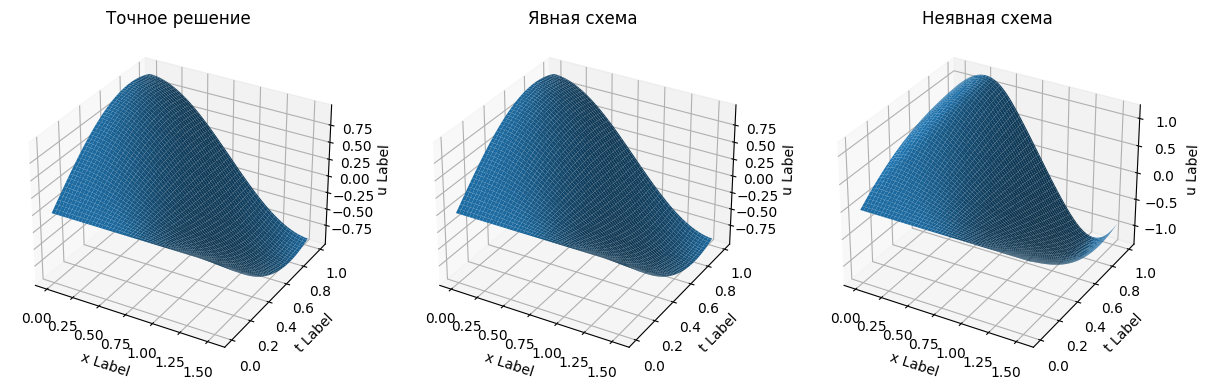

In [487]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 4, 1, projection='3d')
ax.set_title('Точное решение')

U = solver.analyticSolve()

W, Q= np.meshgrid(X, T)
ax.plot_surface(W, Q, np.array(U))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')

# ________________________________________________________________________

ax = fig.add_subplot(1, 4, 2, projection='3d')
ax.set_title('Явная схема')

u = solver.explicit_solver()

W, Q = np.meshgrid(X, T)
ax.plot_surface(W, Q, np.array(u))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')
print('Явная схема: средкв ошибка:',
      math.sqrt(sum([sum([(U[i][j] - u[i][j])**2 for j in range(len(u[0]))]) for i in range(len(u))])))


# ________________________________________________________________________


ax = fig.add_subplot(1, 4, 3, projection='3d')
ax.set_title('Неявная схема')

u = solver.implicit_solver()

W, Q = np.meshgrid(X, T)
ax.plot_surface(W, Q, np.array(u))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')
print('Неявная схема: средкв ошибка:',
            math.sqrt(sum([sum([(U[i][j] - u[i][j])**2 for j in range(len(u[0]))]) for i in range(len(u))])))

